## Categorising countries

### Data Source

The data used in this task was orginally sourced from Help.NGO. This international non-governmental organisation specialises in emergency response, preparedness, and risk mitigation.  

### Dataset Attributes
- country: name of the country
- child_mort: death of children under 5 years of age per 1000 live births
- exports: exports of goods and services per capita. Given as a percentage of the GDP per capita
- health: total health spending per capita. Given as a percentage of GDP per capita
- imports: imports of goods and services per capita. Given as a percentage of the GDP per capita
- income: net income per person
- inflation: the measurement of the annual growth rate of the Total GDP
- life_expec: the average number of years a new born child would live if the current mortality patterns remain the same
- total_fer: the number of children that would be born to each woman if the current age-fertility rates remains the same
- gdpp: the GDP per capita. Calculated as the Total GDP divided by the total population.

## Objective  
To group countries using socio-economic and health factors to determine the development status of the country.

In [63]:
# Import libraries
import numpy as np
import pandas as pd

import warnings
warnings.filterwarnings(action='ignore', category=FutureWarning)

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import MinMaxScaler

In [64]:
# Random state seed
rseed = 42

## Load and explore data

In [65]:
# Import the dataset
df = pd.read_csv('Country-data.csv',index_col = 0)

print('Data:')
print(df.head(), end='\n\n')


Data:
                     child_mort  exports  health  imports  income  inflation  \
country                                                                        
Afghanistan                90.2     10.0    7.58     44.9    1610       9.44   
Albania                    16.6     28.0    6.55     48.6    9930       4.49   
Algeria                    27.3     38.4    4.17     31.4   12900      16.10   
Angola                    119.0     62.3    2.85     42.9    5900      22.40   
Antigua and Barbuda        10.3     45.5    6.03     58.9   19100       1.44   

                     life_expec  total_fer   gdpp  
country                                            
Afghanistan                56.2       5.82    553  
Albania                    76.3       1.65   4090  
Algeria                    76.5       2.89   4460  
Angola                     60.1       6.16   3530  
Antigua and Barbuda        76.8       2.13  12200  



In [66]:
# Check the shape
df.shape

(167, 9)

In [67]:
# Check datatypes & counts
print(df.info())

<class 'pandas.core.frame.DataFrame'>
Index: 167 entries, Afghanistan to Zambia
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   child_mort  167 non-null    float64
 1   exports     167 non-null    float64
 2   health      167 non-null    float64
 3   imports     167 non-null    float64
 4   income      167 non-null    int64  
 5   inflation   167 non-null    float64
 6   life_expec  167 non-null    float64
 7   total_fer   167 non-null    float64
 8   gdpp        167 non-null    int64  
dtypes: float64(7), int64(2)
memory usage: 13.0+ KB
None


In [68]:
# Get descriptive statistics
df.describe()

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
count,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000
mean,38.270060,41.108976,6.815689,46.890215,17144.688623,7.781832,70.555689,2.947964,12964.155689
std,40.328931,27.412010,2.746837,24.209589,19278.067698,10.570704,8.893172,1.513848,18328.704809
min,2.600000,0.109000,1.810000,0.065900,609.000000,-4.210000,32.100000,1.150000,231.000000
25%,8.250000,23.800000,4.920000,30.200000,3355.000000,1.810000,65.300000,1.795000,1330.000000
50%,19.300000,35.000000,6.320000,43.300000,9960.000000,5.390000,73.100000,2.410000,4660.000000
75%,62.100000,51.350000,8.600000,58.750000,22800.000000,10.750000,76.800000,3.880000,14050.000000
max,208.000000,200.000000,17.900000,174.000000,125000.000000,104.000000,82.800000,7.490000,105000.000000


In [69]:
# Identify any missing data
print(df.isnull().sum(), end ='\n\n')

child_mort    0
exports       0
health        0
imports       0
income        0
inflation     0
life_expec    0
total_fer     0
gdpp          0
dtype: int64



## Feature Selection

There are no non-numeric or categorical columns and no data is missing. All the columns are numerical and ready for feature selection.

<Axes: >

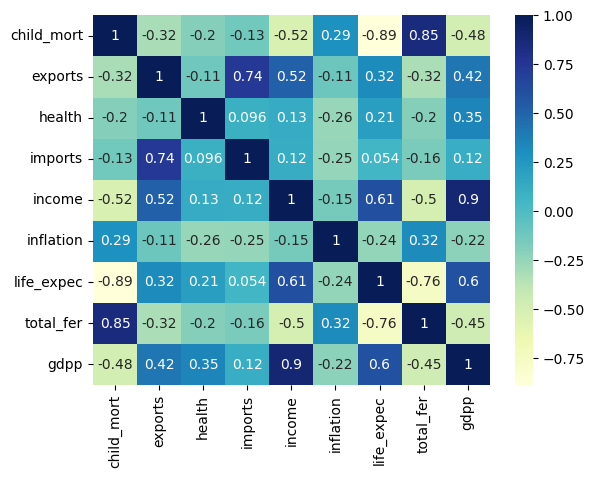

In [70]:
# Create a correlation map of features to explore relationships between features

sns.heatmap(df.corr(), annot = True, cmap = 'YlGnBu')

The following features have the strongest correlations with each other:

Child Mortality and life expenctancy (-0.89)  
Child mortality and total fertility (0.85)  
Exports and Imports (0.74)  
Income and GDP (0.9)  
Life expenctancy and total fertility (-0.76)  

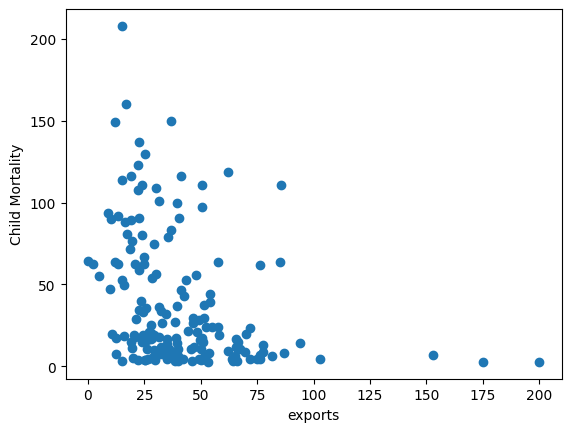

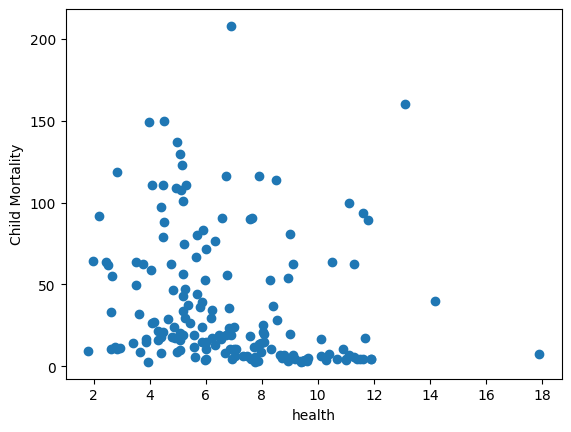

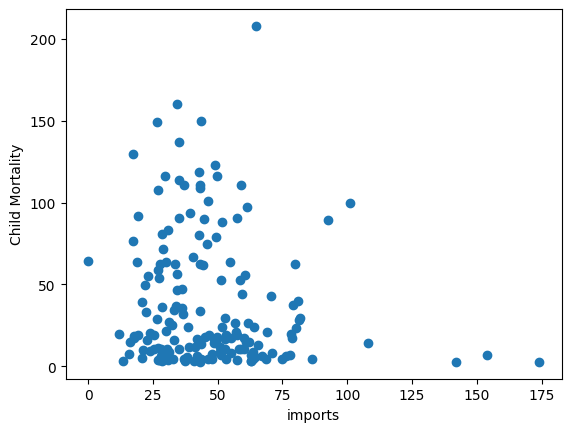

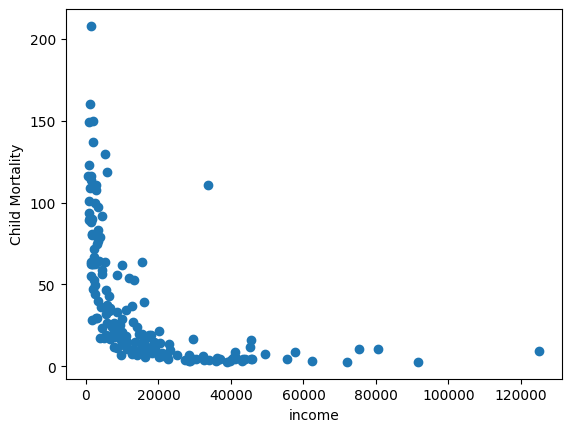

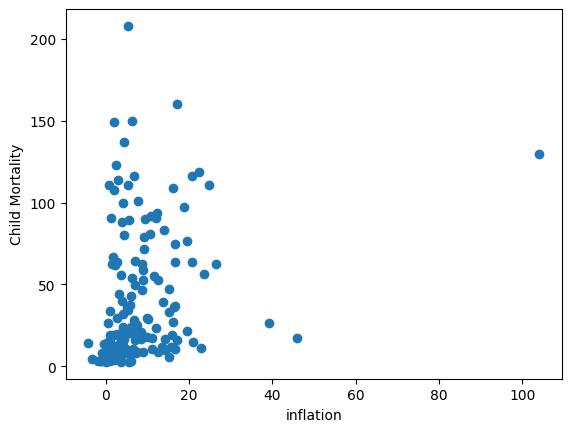

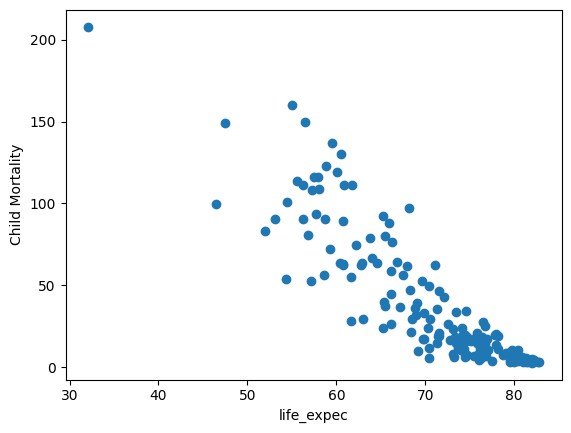

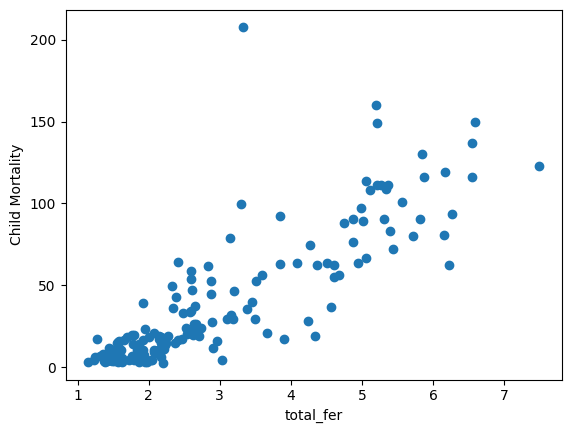

In [71]:
# Explore the continuous independent features against child mortality using scatter plots.
for f in df.columns[1:-1]:
  plt.scatter(df[f], df['child_mort'])
  plt.xlabel(f)
  plt.ylabel('Child Mortality')
  plt.show()


The features that look promising for seperating into clusters are exports, total_fer, life_expec and income. There is a clear linear relationship observed between child mortality vs life expectancy and total fertility. The relationship between income and child_mort is non-linear. While there is no clear pattern observed between exports and child mortality, it appears that the data is split into 2 clusters.

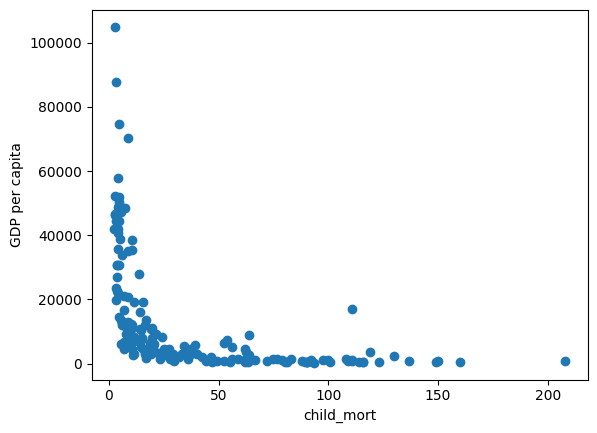

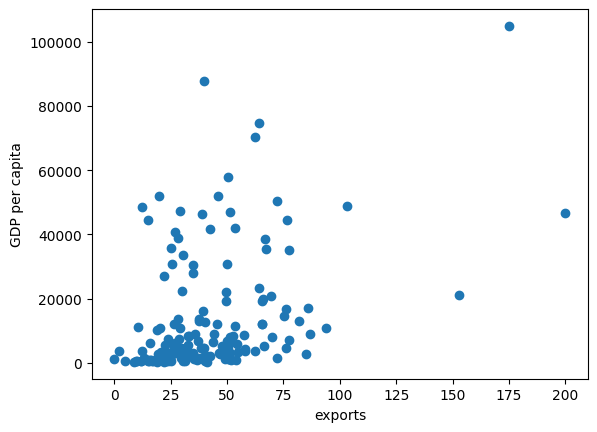

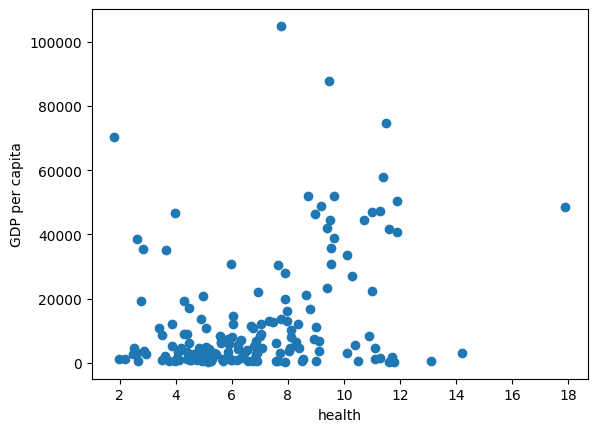

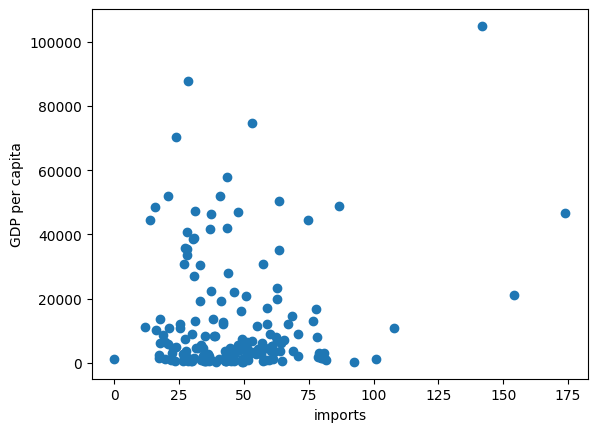

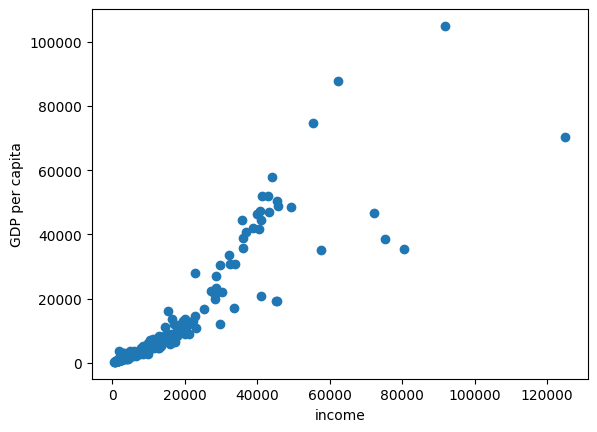

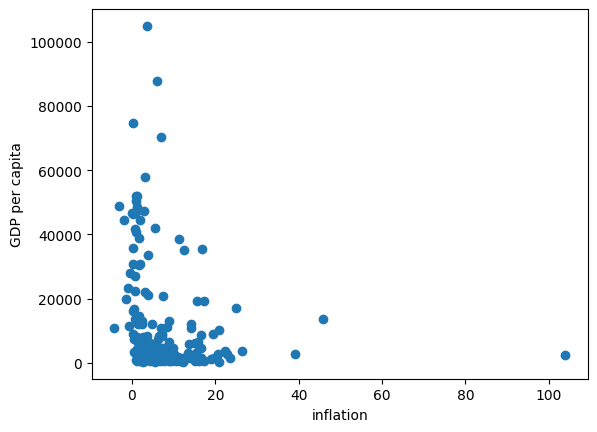

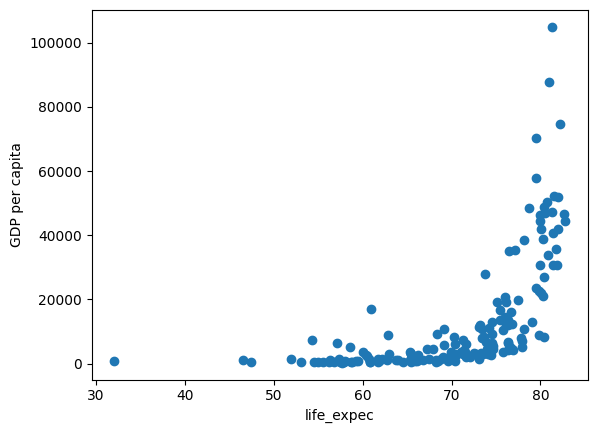

In [72]:
# Explore the continuous independent features against gdpp using scatter plots.
for f in df.columns[:-2]:
  plt.scatter(df[f], df['gdpp'])
  plt.xlabel(f)
  plt.ylabel('GDP per capita')
  plt.show()

The features that look promising for seperating into clusters are child mortality, income and life_expectancy. Total_fertility and child_mortality seem to have a clear non-linear relationship with gdpp. Income vs gdpp have a linear relationship.

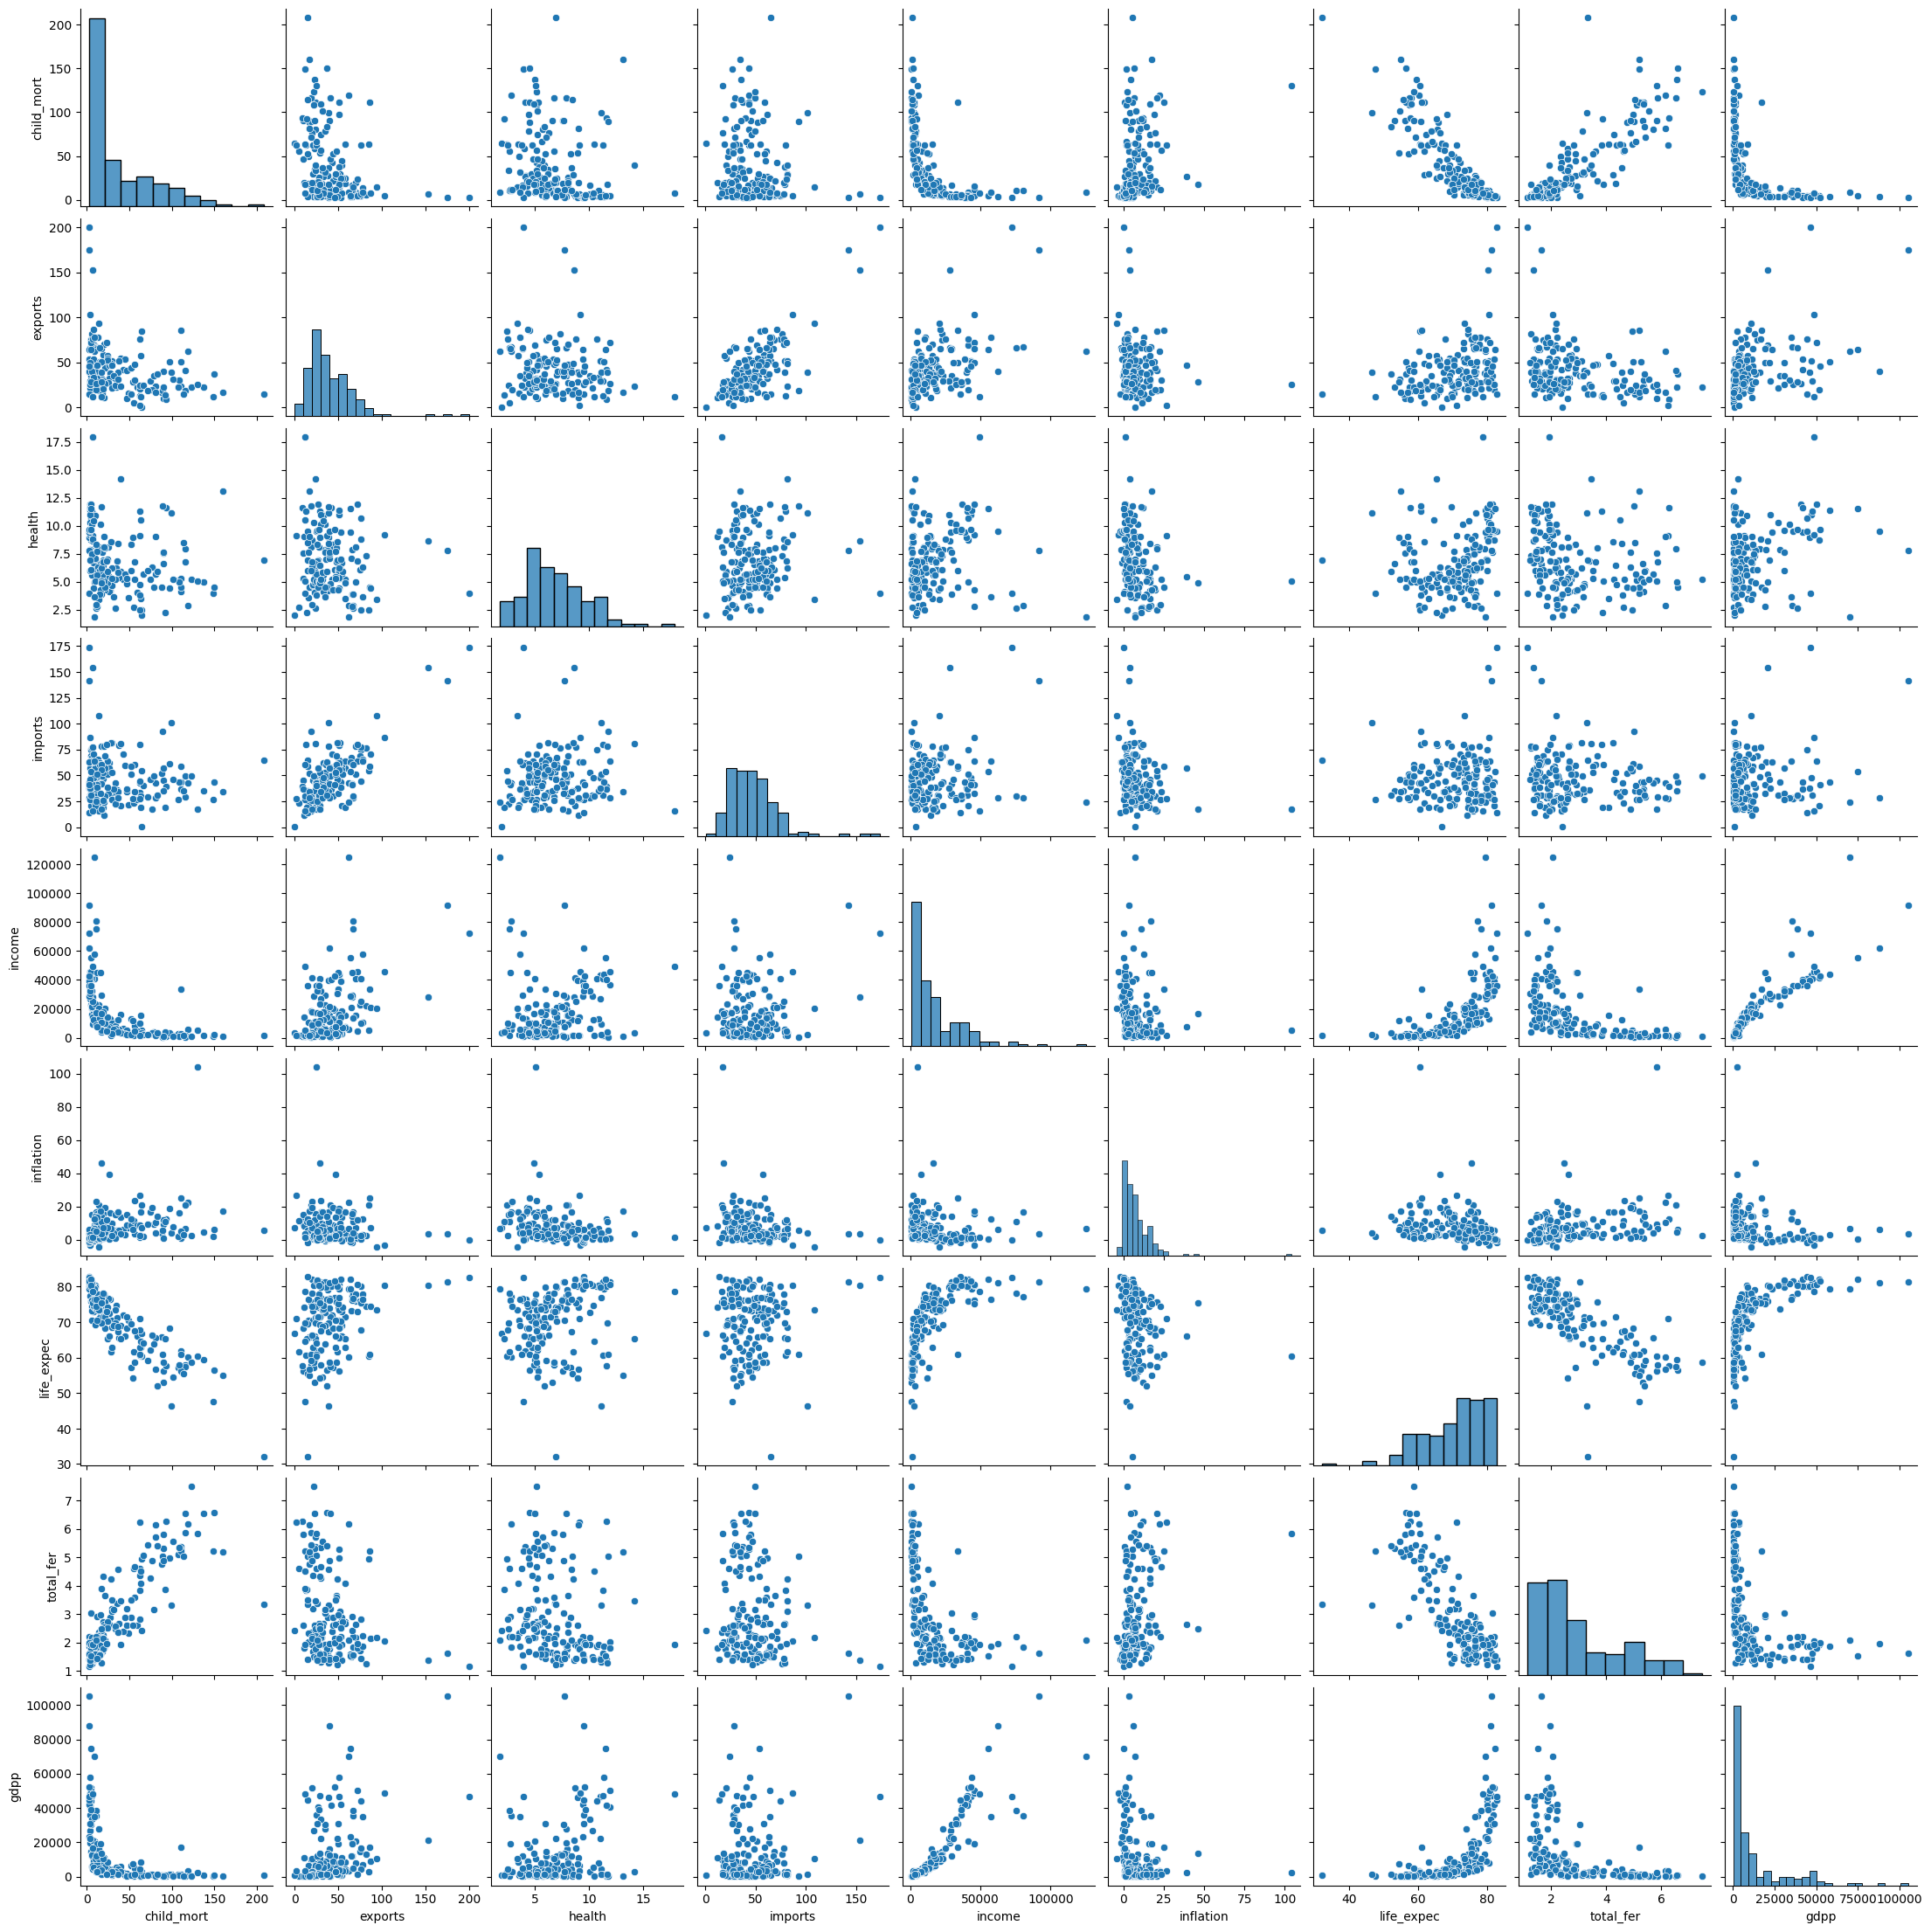

In [73]:
# Create a pair plot
sns.pairplot(df)

### Scaling the Data

The variables look non-gaussian so MinMaxScaler is needed to scale the data

In [74]:
# Normalise the data using MinMaxScaler
# Name the normalised dataframe "df_scaled"

sc = MinMaxScaler()
scaled_data = sc.fit_transform(df)

df_scaled = pd.DataFrame(scaled_data, columns = df.columns)
df_scaled.head()

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,0.426485,0.049482,0.358608,0.257765,0.008047,0.126144,0.475345,0.736593,0.003073
1,0.068160,0.139531,0.294593,0.279037,0.074933,0.080399,0.871795,0.078864,0.036833
2,0.120253,0.191559,0.146675,0.180149,0.098809,0.187691,0.875740,0.274448,0.040365
3,0.566699,0.311125,0.064636,0.246266,0.042535,0.245911,0.552268,0.790221,0.031488
4,0.037488,0.227079,0.262275,0.338255,0.148652,0.052213,0.881657,0.154574,0.114242


## K-Means Clustering

### Selecting K

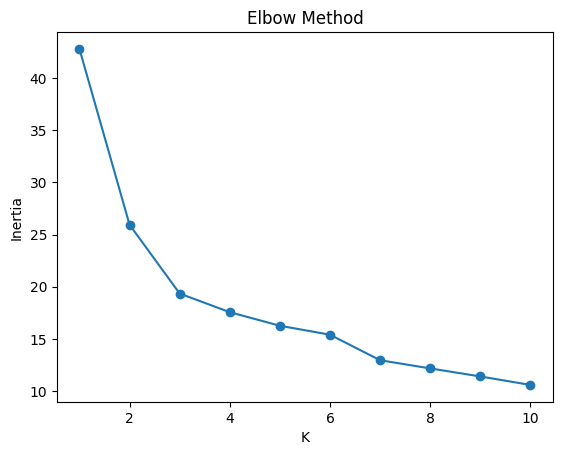

In [75]:
# Plot elbow curve
def eval_Kmeans(x, k, r):
    kmeans = KMeans(n_clusters = k, random_state = r, max_iter = 500)
    kmeans.fit(x)
    return kmeans.inertia_

def elbow_Kmeans(x, max_k = 10, r = 42):
    within_cluster_vars = [eval_Kmeans(x, k, r) for k in range(1, max_k+1)]
    plt.plot(range(1, 11), within_cluster_vars,marker = 'o')
    plt.xlabel('K')
    plt.ylabel('Inertia')
    plt.title('Elbow Method')
    plt.show()

    # Plot elbow curve using scaled dataset
elbow_Kmeans(df_scaled)

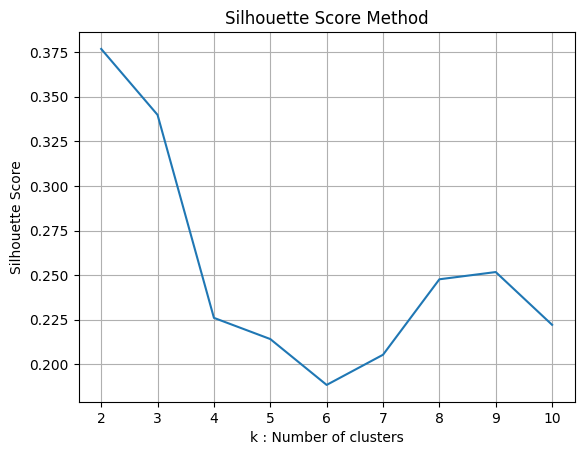

In [76]:
# Silhouette score method
kmax = 10
sil = []
plt.plot()
for k in range(2, kmax+1):
    kmeans = KMeans(n_clusters = k, random_state = rseed, max_iter = 500)
    kmeans.fit(df_scaled)
    labels = kmeans.labels_
    sil.append(silhouette_score(df_scaled, labels, metric = 'euclidean'))

sns.lineplot(x = range(2, kmax+1), y = sil)
plt.title('Silhouette Score Method')
plt.xlabel('k : Number of clusters')
plt.ylabel("Silhouette Score")
plt.grid(visible = True)
plt.show()

Best k value is between 2-4 using elbow method. Therefore the silhouette method is used to narrow down the values. The silhouette score closest to 1 is when 2 clusters are used. Therefore the selected k value is 2. 

## Fitting a K-Means Model with the selected K value

In [77]:
# Fitting K-means model with 2 clusters
rseed = 42
kmeans = KMeans(n_clusters = 2, random_state = 42)
kmeans.fit(df_scaled)

# Add cluster labels column to the scaled df
df_scaled['Cluster'] = kmeans.labels_
df_scaled.head()

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,Cluster
0,0.426485,0.049482,0.358608,0.257765,0.008047,0.126144,0.475345,0.736593,0.003073,0
1,0.068160,0.139531,0.294593,0.279037,0.074933,0.080399,0.871795,0.078864,0.036833,1
2,0.120253,0.191559,0.146675,0.180149,0.098809,0.187691,0.875740,0.274448,0.040365,1
3,0.566699,0.311125,0.064636,0.246266,0.042535,0.245911,0.552268,0.790221,0.031488,0
4,0.037488,0.227079,0.262275,0.338255,0.148652,0.052213,0.881657,0.154574,0.114242,1


In [78]:
# Count the number of records in each cluster
cluster_counts = df_scaled['Cluster'].value_counts()
print("Number of records in each cluster:")
print(cluster_counts)

Number of records in each cluster:
Cluster
1    112
0     55
Name: count, dtype: int64


In [79]:
# Check model performance with the silhouette coefficient
silhouette_score = silhouette_score(df_scaled, labels)

print("The average silhouette score is:", silhouette_score)

The average silhouette score is: 0.14499410901189844


The silhouette score is 0.145 indicating that the data points in the clusters are not close together and there is some overlap between clusters. We can improve the silhouette score by focusing on features with the highest amount of variance (PCA) or choosing a different method of analysis.

## Predictions

In [80]:
# Add the predicted cluster label column to the original dataframe
df['Cluster'] = kmeans.labels_
df.head()

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,Cluster
country,,,,,,,,,,
Afghanistan,90.2,10.0,7.58,44.9,1610,9.44,56.2,5.82,553,0
Albania,16.6,28.0,6.55,48.6,9930,4.49,76.3,1.65,4090,1
Algeria,27.3,38.4,4.17,31.4,12900,16.10,76.5,2.89,4460,1
Angola,119.0,62.3,2.85,42.9,5900,22.40,60.1,6.16,3530,0
Antigua and Barbuda,10.3,45.5,6.03,58.9,19100,1.44,76.8,2.13,12200,1


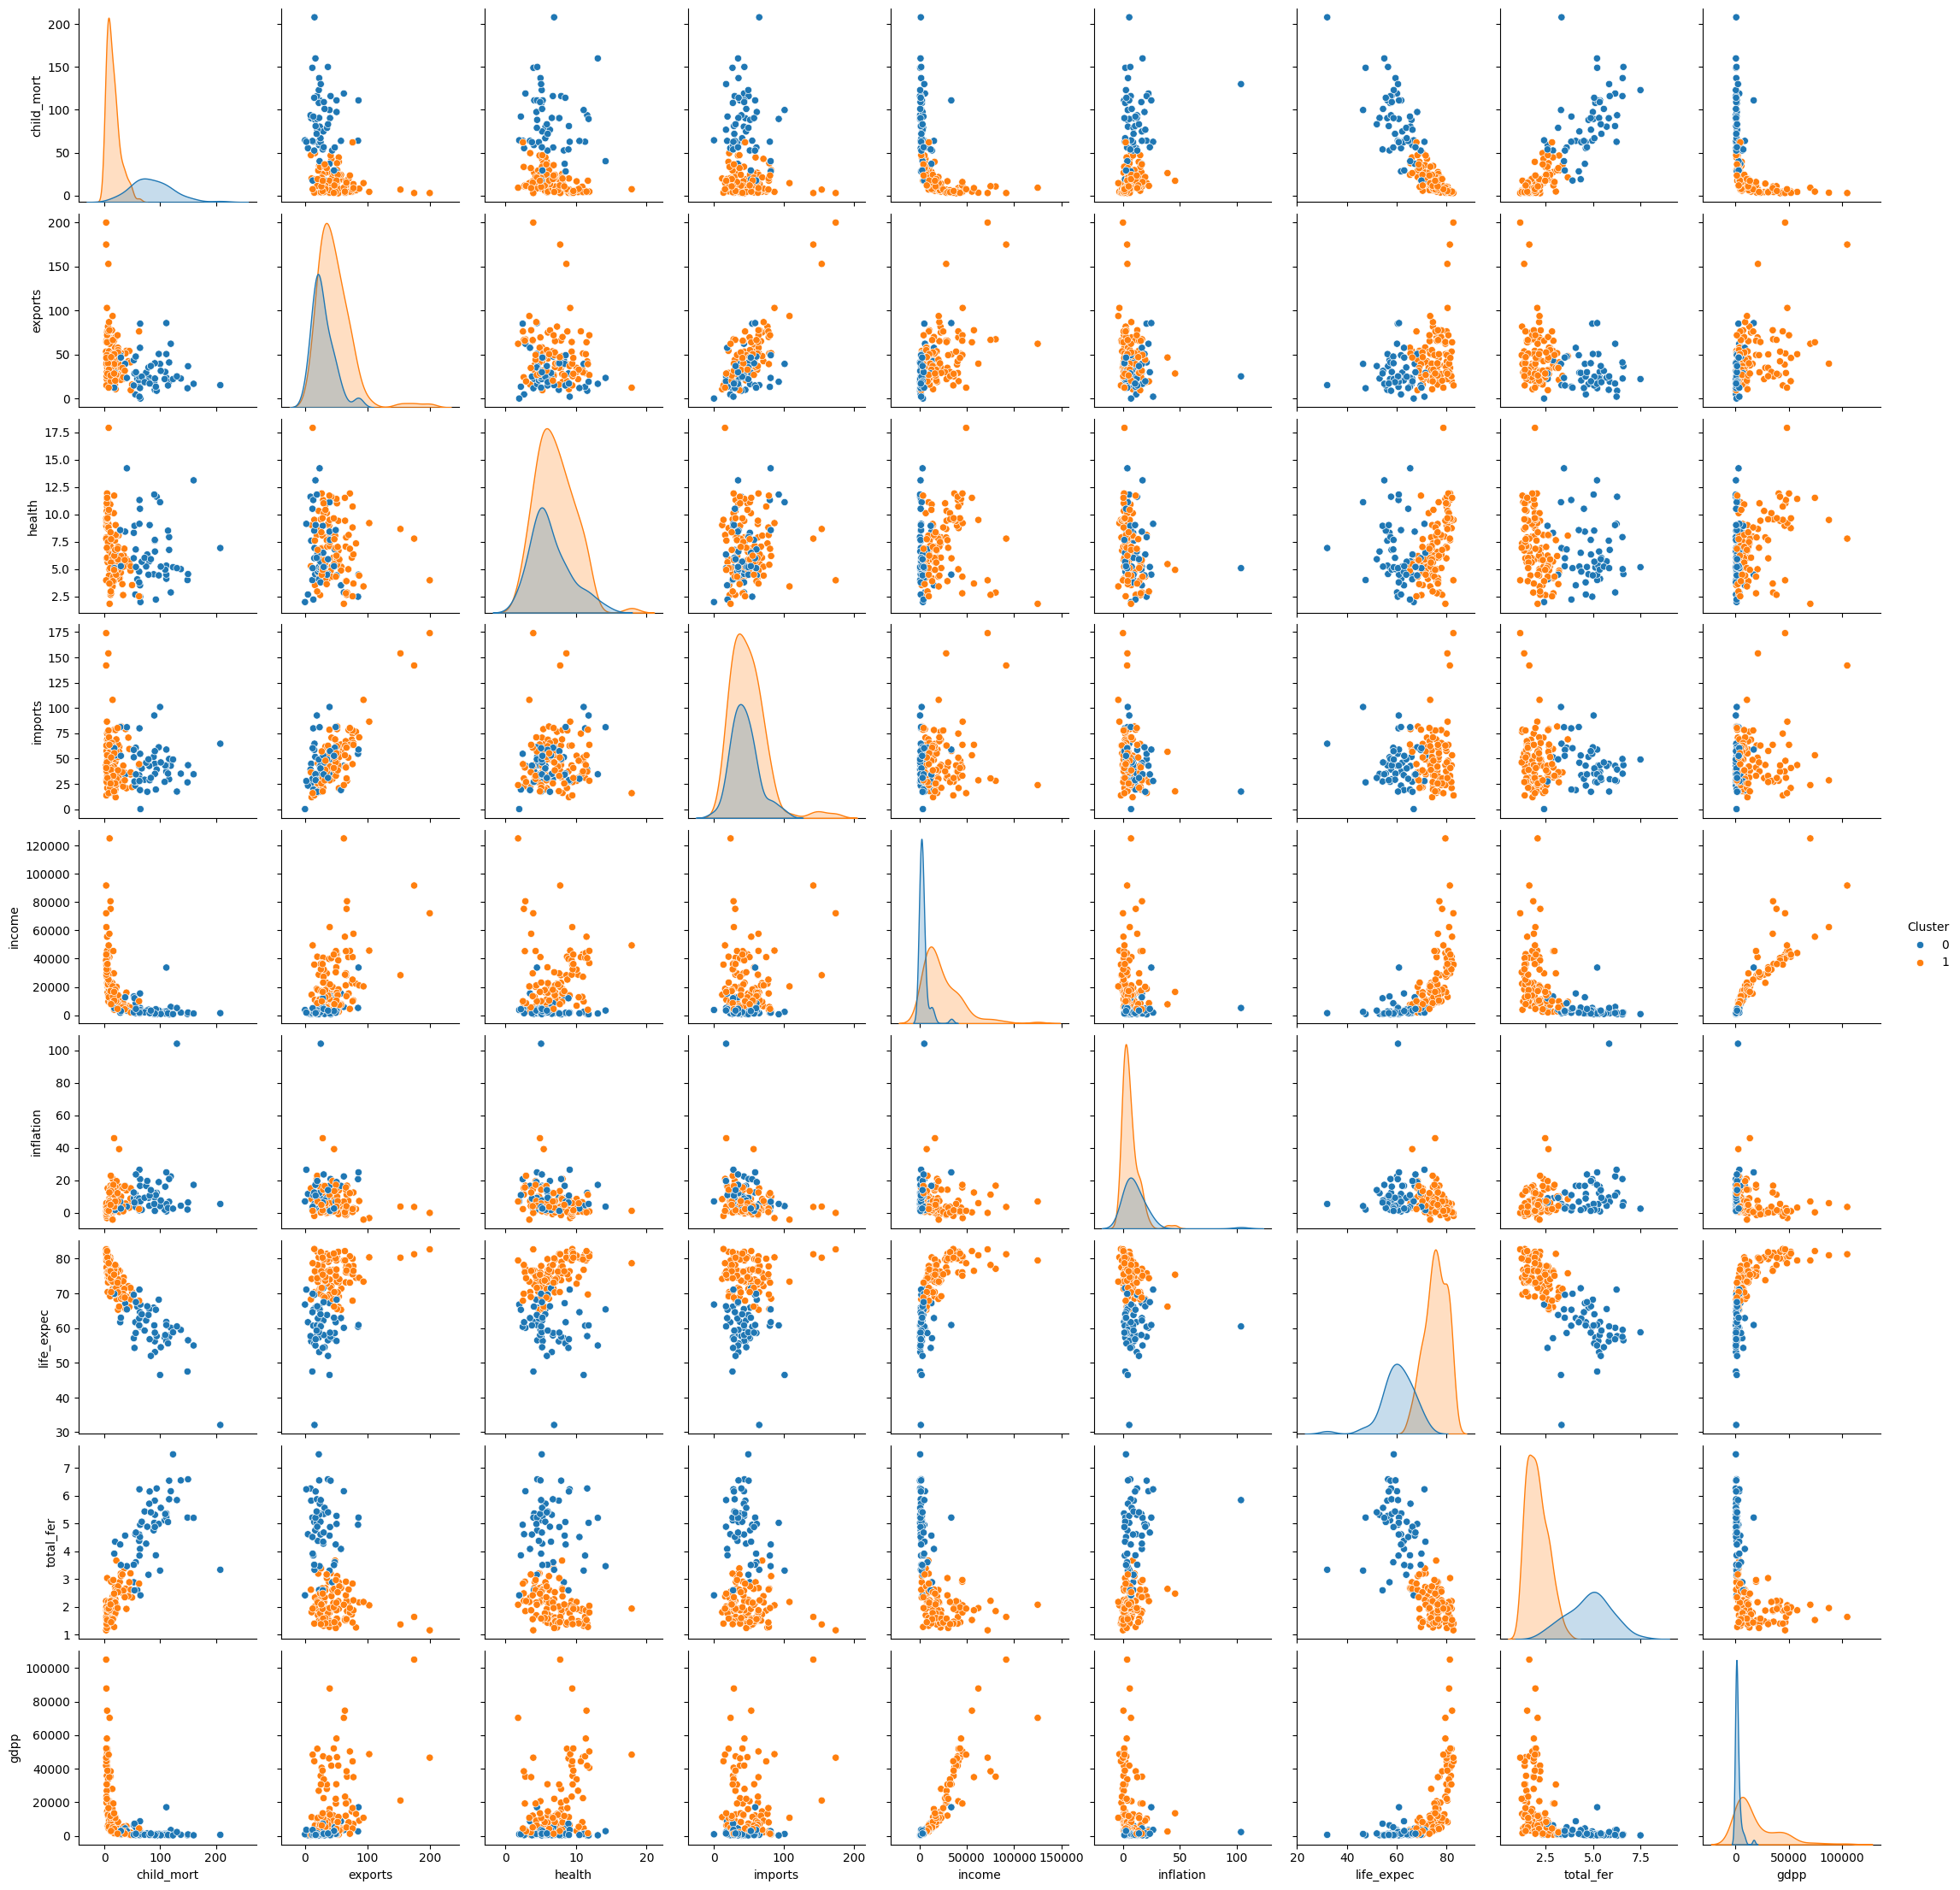

In [81]:
# Create a pair plot
sns.pairplot(df, hue = 'Cluster')

The pair plot above visualises the reasoning for low silhouette score. There appears to be considerable overlap between the two clusters for most features. The only features with relatively distinct clusters are total_fer, life_expec and child_mort. There is some overlap in clustering with gdpp and income.

## Visualisation of clusters

In [82]:
# Give each cluster a name
cluster_names = {
    0: 'Developing',
    1: 'Developed',
 }

# Map the cluster names to the 'Cluster' column
df['Cluster'] = df['Cluster'].map(cluster_names)

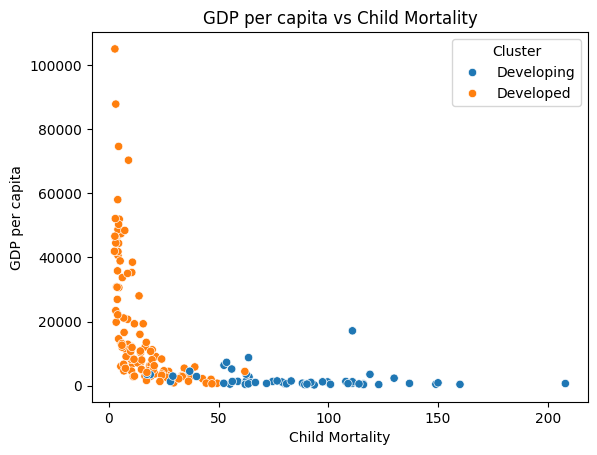

In [84]:
# Visualisation of clusters: child mortality vs gdpp
sns.scatterplot(x = 'child_mort', y = 'gdpp', data = df, hue = 'Cluster')
plt.xlabel('Child Mortality')
plt.ylabel('GDP per capita')
plt.title('GDP per capita vs Child Mortality')
plt.show()

The relationship between GDPP and Child mortality is not linear. This is because child mortality cannot be a negative value. Developing countries have higher rates of child mortatlity and much lower gdp per capita. 

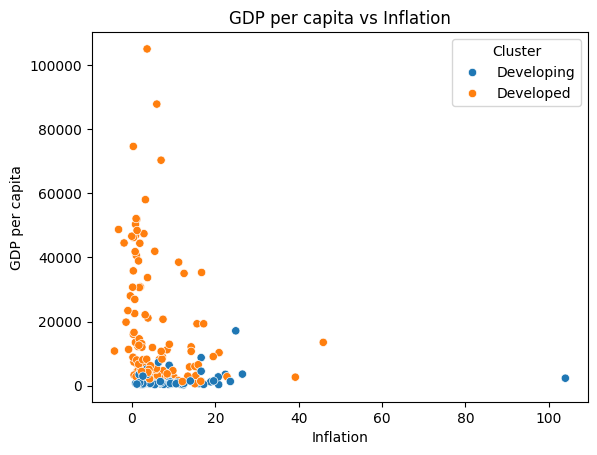

In [85]:
# Visualisation of clusters: inflation vs gdpp
sns.scatterplot(x = 'inflation', y = 'gdpp', data = df, hue = 'Cluster')
plt.xlabel('Inflation')
plt.ylabel('GDP per capita')
plt.title('GDP per capita vs Inflation')
plt.show()

There is not clear relationship or clustering between GDPP and inflation. Developed countries seem to have higher range of gdp per capita but inflation appears to be similar betweem the two clusters.

In [103]:
# Cluster characteristics
df.groupby('Cluster').mean()

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
Cluster,,,,,,,,,
Developed,15.291964,47.290000,7.021607,48.458929,23653.392857,6.138312,75.597321,2.044286,18370.232143
Developing,85.061818,28.522164,6.396364,43.695744,3890.600000,11.128636,60.289091,4.788182,1955.418182


## Conclusions

The clusters have been labelled as 'Developing' and 'Developed' based on the average of socio-economic indicators analysed above. Developing countries on average have lower values for gdp per capita, income, imports and exports. The life expectancy is also lower indicating poorer health factors and higher child mortality. However, this grouping is not fully accurate due to the considerable overlap in clusters for most of the features.  

Developed countries have higher average values for income, gdpp etc indicating better socio-economic conditions. This is also reflected in lower child mortality rates due to better health conditions and higher life expectancy.

total_fer feature is higher for developing countries compared to developed countries. This means that the number of children born per women (given equal fertility rate) is lower for developed countries. This maybe correlated with lower child mortality rate for the same group.

The following can be done to improve the model:
- Only selecting the features that are relevant for analysis
- Using PCA to reduce features but still have high variance
- reanalyse the model again for finding the optimal number of clusters